# Bases

## Contexte

Dans `first_steps.py`, on a construit un graphe simple avec des noeuds, des arêtes régulières et conditionnelles.

Construisons maintenant une chaîne simple qui combine quatre concepts d'une app conversationnel.

- Utiliser les [messages](https://docs.langchain.com/oss/python/langchain/messages) comme état du graphe
- Utiliser des [modèles conversationnels](https://docs.langchain.com/oss/python/integrations/chat) dans les noeuds du graphe
- [Lier des outils](https://docs.langchain.com/oss/python/langchain/models#tool-calling) à notre modèle conversationnel
- [Exécuter des appels d'outils](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) dans les noeuds du graphe

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [29]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Messages

Les modèles conversationnels peuvent utiliser des [messages](https://docs.langchain.com/oss/python/langchain/messages), dont le type diffère:
- `HumanMessage`: utilisateur
- `AIMessage`: modèle conversationnel
- `SystemMessage`: instructions sur le comportement du modèle
- `ToolMessage`: réponse d'appel à l'outil

Chaque message peut contenir plusieurs éléments:

- `content`: le contenu du message
- `name`: optionnellement, l'auteur du message
- `response_metadata`: optionnellement, des métadonnées liées à la réponse (au format d'un liste associative)

In [30]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"Alors tu cherches à comprendre les tests de performance?", name="Model")]
messages.append(HumanMessage(content=f"Oui, c'est ça.",name="John"))
messages.append(AIMessage(content=f"Bien, que veux-tu savoir en particulier?", name="Model"))
messages.append(HumanMessage(content=f"Je veux savoir ce que l'IA apporte aux tests de performances.", name="John"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Alors tu cherches à comprendre les tests de performance?
================================ Human Message =================================
Name: John

Oui, c'est ça.
================================== Ai Message ==================================
Name: Model

Bien, que veux-tu savoir en particulier?
================================ Human Message =================================
Name: John

Je veux savoir ce que l'IA apporte aux tests de performances.


## Modèles conversationnels

On peut intégrer [plusieurs fournisseurs de modèles](https://docs.langchain.com/oss/python/integrations/chat) mais cette formation utilisera OpenAI.

In [31]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Continuons avec notre exemple.

In [32]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [33]:
result

AIMessage(content="L'intelligence artificielle (IA) apporte plusieurs avantages significatifs aux tests de performance, en améliorant leur efficacité, leur précision et leur adaptabilité. Voici quelques manières clés dont l'IA influe sur les tests de performance :\n\n1. **Automatisation Intelligente** : L'IA permet l'automatisation des tests de performance à un niveau très avancé. Les algorithmes d'apprentissage automatique peuvent automatiser la création, l'exécution et l'analyse des tests, réduisant ainsi le besoin d'une intervention humaine constante.\n\n2. **Analyse Prédictive** : Les capacités d'analyse prédictive de l'IA peuvent être utilisées pour anticiper les problèmes de performance avant qu'ils ne surviennent. L'IA peut analyser des données historiques pour identifier des tendances et des schémas qui pourraient mener à des problèmes, permettant ainsi de les traiter proactivement.\n\n3. **Détection Anomalies** : L'IA est efficace pour détecter les anomalies dans le comporteme

In [34]:
result.response_metadata

{'token_usage': {'completion_tokens': 472,
  'prompt_tokens': 67,
  'total_tokens': 539,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_provider': 'openai',
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_cbf1785567',
 'id': 'chatcmpl-CYzoOyWCYGMS2ais2ClU6KpJXkoJ1',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Outils

Les outils permettent au modèle d'interagir avec des systèmes externes (tels qu'une base de données, un calendrier ou une boîte mail).

Le modèle choisira d'appeler un outil en fonction de l'entrée en langage naturel fournie par l'utilisateur et il renverra une sortie qui respecte le schéma de réponse de l'outil.

[Nombreux fournisseurs prennent en charge l'appel d'outils](https://docs.langchain.com/oss/python/integrations/chat) et l'[interface d'appel d'outils](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) dans LangChain est simplifié pour.

On utilise `ChatModel.bind_tools(function)` pour lier un outil au modèle.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Prenons la multiplication comme outil.

In [35]:
def multiply(a: int, b: int) -> int:
    """Multiplie a avec b?

    Args:
        a: entier
        b: entier
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

L'appel d'outil contient des arguments spécifiques correspondant au schéma d'entrée de notre fonction ainsi que le nom de la fonction à appeler.

```
{'arguments': '{"a":8,"b":12}', 'name': 'multiply'}
```

In [36]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Multiplie 8 par 12.", name="John")])

In [37]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 8, 'b': 12},
  'id': 'call_R3BhrmhvaeNFSdJ2Et1Hl2ww',
  'type': 'tool_call'}]

## Messages comme état

On peut maintenant utiliser les [messages](https://docs.langchain.com/oss/python/langchain/overview#messages) dans l'état de notre graphe.

Définissons notre état: `MessagesState` comme un `TypedDict` avec une seule clef: `messages`, qui est une liste de messages.

In [38]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Réducteurs

Nous avons maintenant un petit problème !

Comme mentionné, chaque nœud retournera une nouvelle valeur pour notre clef d'état `messages`.

Mais, cette nouvelle valeur écrasera la valeur précédente de `messages` !

Au fur et à mesure que notre graphe s'exécute, nous voulons **ajouter*- des messages à notre clef d'état `messages`.

Nous pouvons utiliser des [fonctions réductrices](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers) pour résoudre cela.

Les réducteurs spécifient comment les mises à jour d'état sont effectuées.

Si aucune fonction réductrice n'est spécifiée, il est supposé que les mises à jour de la clef doivent *l'écraser*, comme nous l'avons vu précédemment.

Mais, pour ajouter des messages, nous pouvons utiliser le réducteur pré-construit `add_messages`.

Cela garantit que tous les messages sont ajoutés à la liste existante de messages.

Nous devons simplement annoter notre clef `messages` avec la fonction réductrice `add_messages` en tant que métadonnée.

In [39]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

On utilisera généralement `MessagesState` car il est moins verbeux que la définition d'un `TypedDict` personnalisé. Il est défini par:
- une clef unique `messages`
- une liste d'objets `AnyMessage`
- le réducteur `add_messages`

In [40]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Ajoutez des clefs supplémentaires au-delà de messages si nécessaire, qui est pré-construit
    pass

Analysons le comportement de `add_messages`.

In [41]:
# état initial
initial_messages = [AIMessage(content="Bonjour, comment puis-je vous assister?", name="Model"),
                    HumanMessage(content="Je cherche des informations au sujet de LangGraph.", name="John")
                   ]

# ajout d'un nouveau message
new_message = AIMessage(content="Bien, que souhaites-tu savoir en particulier?", name="Model")

# essai
add_messages(initial_messages , new_message)

[AIMessage(content='Bonjour, comment puis-je vous assister?', additional_kwargs={}, response_metadata={}, name='Model', id='bdcf6604-6513-47f3-9c06-1c5e25df6b0f'),
 HumanMessage(content='Je cherche des informations au sujet de LangGraph.', additional_kwargs={}, response_metadata={}, name='John', id='09d05c51-b96d-42f1-b74c-176188be635e'),
 AIMessage(content='Bien, que souhaites-tu savoir en particulier?', additional_kwargs={}, response_metadata={}, name='Model', id='4b40f85c-4ec0-4af7-a453-6a24c6252b0f')]

## Utilisation

Maintenant, utilisons `MessagesState` avec un graphe.

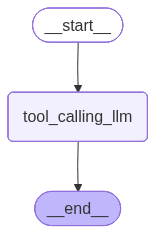

In [42]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# noeud
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"]) ]}

# construction du graphe
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# représentation
display(Image(graph.get_graph().draw_mermaid_png()))

Si nous fournissons `Bonjour!`, le LLM répond sans aucun appel d'outil.

In [43]:
messages = graph.invoke({"messages": HumanMessage(content="Bonjour!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Bonjour!
================================== Ai Message ==================================

Bonjour! Comment puis-je vous aider aujourd'hui ?


Le LLM choisit d'utiliser un outil lorsqu'il détermine que l'entrée ou la tâche nécessite la fonctionnalité fournie par cet outil.

In [44]:
messages = graph.invoke({"messages": HumanMessage(content="Multiplie 8 par 12.")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiplie 8 par 12.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3zekG2BqRehH3OYhfoedKsPX)
 Call ID: call_3zekG2BqRehH3OYhfoedKsPX
  Args:
    a: 8
    b: 12
